# Tree based models

## Why Tree-Based Models for Regression?

**💡 Context:** Tree-based models revolutionize regression by abandoning the assumption of linear relationships. Instead of fitting straight lines through data, they create decision boundaries that split the feature space into regions, each with its own prediction. This flexibility allows them to capture complex, non-linear patterns that linear models miss entirely.

**Key Advantages:**

- No linearity assumptions: Can model any relationship shape.
- Handles interactions automatically: Discovers feature combinations without manual engineering.
- Mixed data types: Works with numerical and categorical features seamlessly.
- Interpretable decisions: Can trace exact reasoning for any prediction.

**When Trees Excel:**

- Non-linear relationships between features and target.
- Complex feature interactions are important.
- Mix of numerical and categorical variables.
- Need interpretable model decisions.

In [1]:
import time
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
)
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.monitor_model import monitor_model
from utils.complete_model_review import complete_model_review
from utils.tree_model_diagnostics import tree_model_diagnostics
from utils.TreeEnsembleProject import TreeEnsembleProject

# Read the data
X_train = pd.read_csv("../data/processed/X_train.csv")
y_train = pd.read_csv("../data/processed/y_train.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")

target_variable = "volume_per_ha"

In [2]:
X_train.describe()

,id,yield_class,age,average_height,dbh,taper,trees_per_ha
count,3314.000000,3314.000000,3314.000000,3314.000000,3.314000e+03,3.314000e+03,3314.000000
mean,0.315567,0.081774,0.083660,-0.015927,3.327284e-02,3.507575e-02,0.466624
std,0.480311,0.774593,0.674642,0.656479,6.789717e-01,9.506453e-01,1.379298
min,-0.222222,-1.166667,-0.875000,-1.418486,-1.358647e+00,-8.230458e+00,-0.680350
25%,-0.135802,-0.500000,-0.500000,-0.520006,-5.022370e-01,-3.793940e-01,-0.302153
50%,0.000000,0.000000,0.000000,0.000000,-9.996344e-17,-5.999975e-16,0.000000
75%,0.864198,0.500000,0.500000,0.479994,4.977630e-01,6.206060e-01,0.697847
max,0.913580,3.666667,2.000000,1.625933,2.733660e+00,1.142912e+01,18.971063


In [4]:
models = {
    "DecisionTree": DecisionTreeRegressor(max_depth=5),
    "RandomForest": RandomForestRegressor(
        n_estimators=100, max_depth=5, random_state=42
    ),  # Slow as fu**
    "ExtraTrees": ExtraTreesRegressor(n_estimators=100, max_depth=5, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
    ),
    "DGBoost": XGBRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
    ),
}
for name, model in models.items():
    model.fit(X_train, y_train[target_variable])

    score = cross_val_score(model, X_train, y_train[target_variable], cv=5).mean()
    print(f"{name}: {score:.3f}")

DecisionTree: 0.914
RandomForest: 0.946
ExtraTrees: 0.911
GradientBoosting: 0.993
DGBoost: 0.993


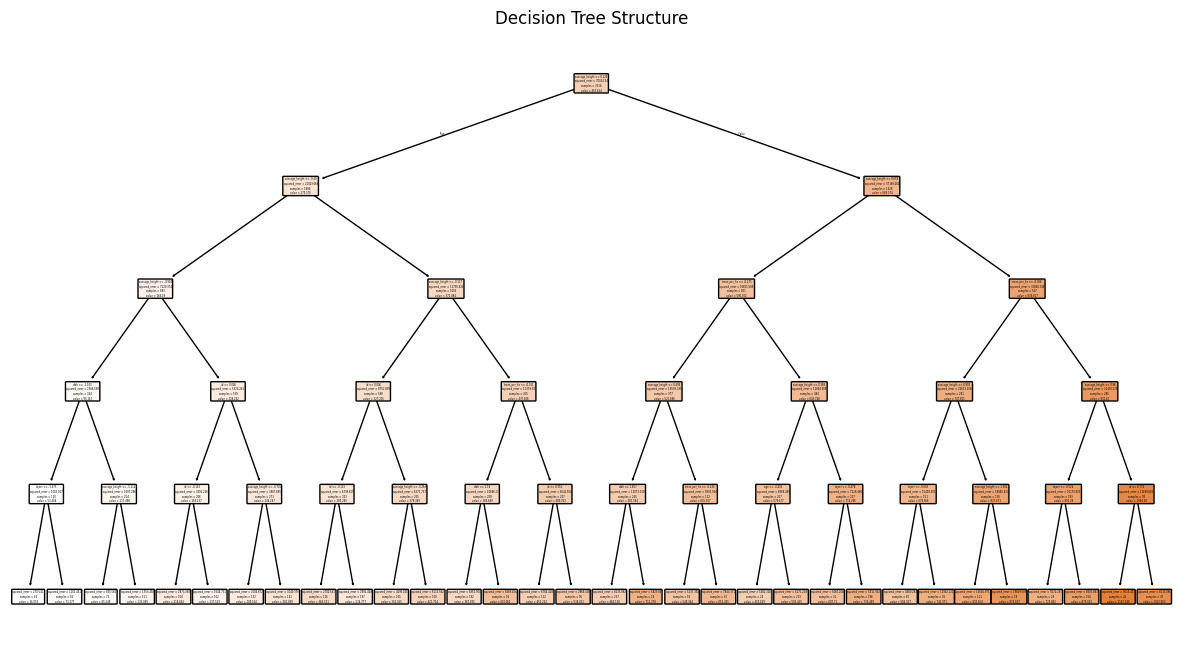

In [5]:
models["DecisionTree"].fit(X_train, y_train)

# Visualize tree structure
plt.figure(figsize=(15, 8))
plot_tree(
    models["DecisionTree"], feature_names=X_train.columns, filled=True, rounded=True
)
plt.title("Decision Tree Structure")
plt.show()

## Controlling Overfitting in Decision Trees

Single decision trees are notorious overfitters - without constraints, they'll create a unique leaf for every training sample, achieving perfect training accuracy but terrible generalization. Controlling tree complexity through hyperparameters is essential for building useful models that perform well on new data.
Key Hyperparameters:

- **max_depth**: Limits tree height (typical range: 3-10)
- **min_samples_split**: Minimum samples required to split a node
- **min_samples_leaf**: Minimum samples required in each leaf
- **max_features**: Fraction of features considered for each split

In [6]:
depths = [1, 3, 5, 6, 7, 10, None]

for depth in depths:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    cv_scores = cross_val_score(tree, X_train, y_train, cv=5)
    print(f"  Depth {depth}: CV R² = {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

  Depth 1: CV R² = 0.593 ± 0.012
  Depth 3: CV R² = 0.827 ± 0.017
  Depth 5: CV R² = 0.914 ± 0.009
  Depth 6: CV R² = 0.934 ± 0.005
  Depth 7: CV R² = 0.945 ± 0.004
  Depth 10: CV R² = 0.966 ± 0.003
  Depth None: CV R² = 0.969 ± 0.003


## Random Forest - Ensemble Power

Random Forest combines many decision trees, each trained on a different subset of data and features. This ensemble approach reduces overfitting while maintaining the flexibility of individual trees. Think of it as consulting multiple experts who each see slightly different perspectives on the same problem - their combined wisdom is more reliable than any single opinion.

**How Random Forest Works:**

- Bootstrap sampling: Each tree trains on a random sample with replacement.
- Feature randomness: Each split considers only a random subset of features.
- Independent training: Trees don't influence each other.
- Averaging predictions: Final prediction is the mean of all tree predictions.

**Why It Works:**

- Reduces variance: Averaging multiple models smooths out individual quirks.
- Maintains low bias: Individual trees can still capture complex patterns.
- Handles overfitting: Randomness prevents trees from memorizing training data.

Top 10 Most Important Features:
          feature  importance
3  average_height    0.699437
4             dbh    0.191421
6    trees_per_ha    0.030447
2             age    0.029081
1     yield_class    0.028925
0              id    0.015986
5           taper    0.004702


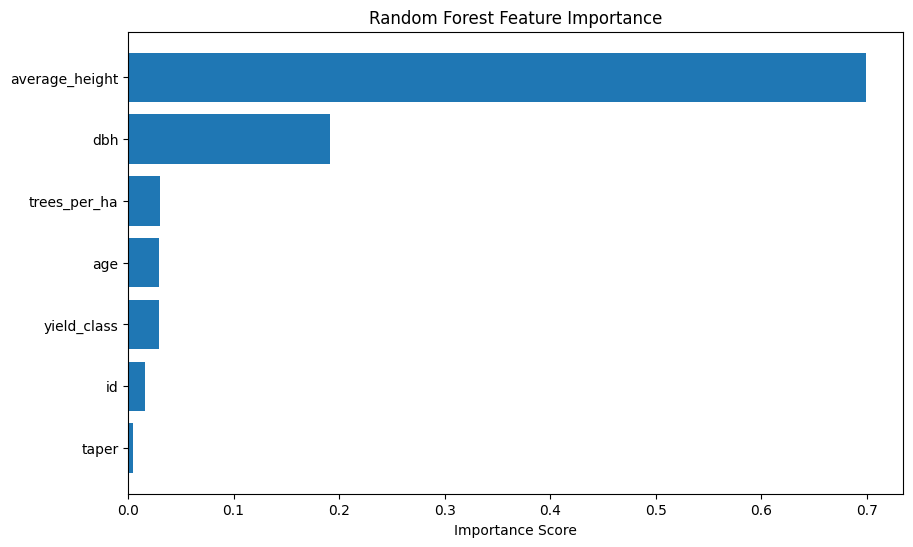

In [7]:
## Get feature importance

importance_df = pd.DataFrame(
    {
        "feature": X_train.columns,
        "importance": models["ExtraTrees"].feature_importances_,
    }
).sort_values("importance", ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Visualize importance
plt.figure(figsize=(10, 6))
top_features = importance_df.head(10)
plt.barh(range(len(top_features)), top_features["importance"])
plt.yticks(range(len(top_features)), top_features["feature"])
plt.xlabel("Importance Score")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()

## Gradient Boosting Fundamentals

Gradient Boosting takes a fundamentally different ensemble approach: instead of training independent trees, it builds them sequentially, with each new tree specifically designed to correct the errors of the previous ensemble. This creates a powerful learning system that gradually improves predictions through focused error correction.

**Boosting Process:**

- **Start simple:** Begin with basic model (often just the mean).
- **Calculate errors:** Find where current ensemble fails.
- **Train corrector:** New tree targets these specific errors.
- **Add with shrinkage:** Combine new tree with reduced weight.
- **Repeat:** Continue until performance plateaus or criteria met.


**Key Concepts:**

- **Sequential learning:** Each tree builds on previous mistakes.
- **Learning rate:** Controls how much each tree contributes.
- **Shrinkage:** Prevents any single tree from dominating.
- **Early stopping:** Halt training when validation performance stops improving.

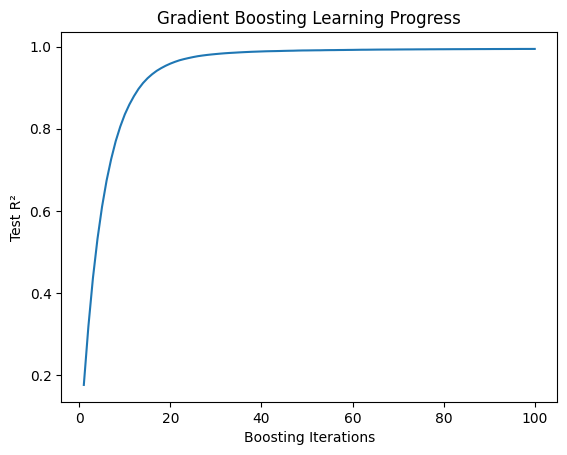

In [8]:
# Show learning progress
test_scores = []
for i, pred in enumerate(models["GradientBoosting"].staged_predict(X_test)):
    score = r2_score(y_test, pred)
    test_scores.append(score)

plt.plot(range(1, len(test_scores) + 1), test_scores)
plt.xlabel("Boosting Iterations")
plt.ylabel("Test R²")
plt.title("Gradient Boosting Learning Progress")
plt.show()

In [9]:
for name, model in models.items():
    pred = model.predict(X_test)
    print(f"{name} R²: {r2_score(y_test, pred):.3f}")

    # Feature importance
    xgb_importance = pd.DataFrame(
        {"feature": X_train.columns, "importance": model.feature_importances_}
    ).sort_values("importance", ascending=False)
    print(f"\nTop 5 {name} Features:")
    print(xgb_importance.head())
    print("\n" * 3)

DecisionTree R²: 0.926

Top 5 DecisionTree Features:
          feature  importance
3  average_height    0.914772
6    trees_per_ha    0.043528
0              id    0.020819
4             dbh    0.009960
5           taper    0.009023




RandomForest R²: 0.954

Top 5 RandomForest Features:
          feature  importance
3  average_height    0.909161
6    trees_per_ha    0.041973
0              id    0.026662
5           taper    0.012564
4             dbh    0.007753




ExtraTrees R²: 0.920

Top 5 ExtraTrees Features:
          feature  importance
3  average_height    0.699437
4             dbh    0.191421
6    trees_per_ha    0.030447
2             age    0.029081
1     yield_class    0.028925




GradientBoosting R²: 0.995

Top 5 GradientBoosting Features:
          feature  importance
3  average_height    0.855138
6    trees_per_ha    0.051300
0              id    0.045460
4             dbh    0.018857
5           taper    0.018763




DGBoost R²: 0.995

Top 5 DGBoost Features:
     

## Hyperparameter Tuning for Tree Ensembles

**Context:** Tree-based ensemble models have many hyperparameters that significantly impact performance. Systematic tuning can dramatically improve results, but the parameter space is large and interactions are complex. Understanding which parameters matter most and efficient search strategies is crucial for practical success.

### Key Parameters by Model:

**Random Forest:**

- n_estimators: Number of trees (more is usually better, with diminishing returns).
- max_depth: Tree complexity control.
- max_features: Feature subset size for splits.

**Gradient Boosting:**

- learning_rate: Step size for each tree contribution.
- n_estimators: Number of boosting rounds.
- max_depth: Individual tree complexity.

**Tuning Strategy:**

- Start simple: Begin with default parameters.
- Grid search: Systematic parameter exploration.
- Random search: Efficient for high-dimensional spaces.
- Sequential tuning: Optimize parameter groups separately.

In [10]:
# Random Forest tuning
rf_params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 10, 15],
    "max_features": ["sqrt", "log2", 0.5],
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42), rf_params, cv=9, scoring="r2", n_jobs=-3
)
rf_grid.fit(X_train, y_train[target_variable])
print(f"Best RF params: {rf_grid.best_params_}")
print(f"Best RF score: {rf_grid.best_score_:.3f}")

Best RF params: {'max_depth': 15, 'max_features': 0.5, 'n_estimators': 200}
Best RF score: 0.993


In [11]:
results = []
for name, model in models.items():
    # Time training
    start_time = time.time()
    model.fit(X_train, y_train[target_variable])
    train_time = time.time() - start_time

    # Evaluate performance
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    results.append({"Model": name, "R²": r2, "Train_Time": train_time})

comparison_df = pd.DataFrame(results)
print("Model Comparison:")
print(comparison_df.round(3))

Model Comparison:
              Model     R²  Train_Time
0      DecisionTree  0.926       0.012
1      RandomForest  0.954       0.392
2        ExtraTrees  0.920       0.092
3  GradientBoosting  0.995       0.598
4           DGBoost  0.995       0.135


## Preventing Overfitting in Tree Ensembles

While ensemble methods reduce overfitting compared to single trees, they can still memorize training data with insufficient regularization. Understanding overfitting symptoms and prevention strategies ensures robust models that generalize well to new data.

**Overfitting Detection:**

- **Learning curves:** Large gap between training and validation performance.
- **Cross-validation variance:** High standard deviation across folds.
- **Validation curves:** Performance peaks then declines with complexity.
- **Feature importance instability:** Rankings change dramatically with small data changes.

**Prevention Strategies:**

- **Early stopping:** Monitor validation performance during training.
- **Regularization:** Use built-in penalties in XGBoost/LightGBM.
- **Ensemble size limits:** Don't add trees beyond performance plateau.
- **Cross-validation:** Use robust validation for hyperparameter selection.

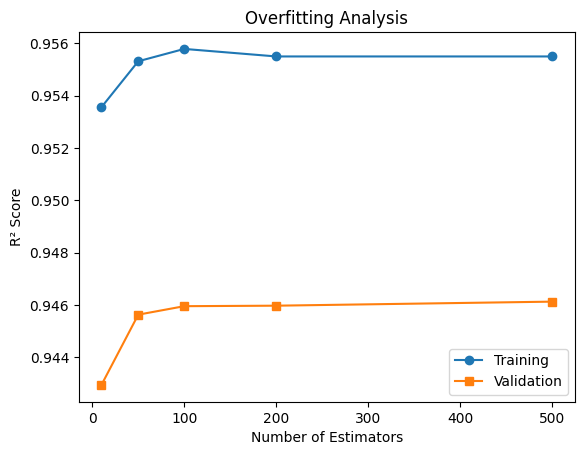

In [12]:
train_scores = []
val_scores = []
n_estimators_range = [10, 50, 100, 200, 500]

for n_est in n_estimators_range:
    rf = RandomForestRegressor(n_estimators=n_est, random_state=42, max_depth=5)

    # Cross-validation
    cv_scores = cross_val_score(rf, X_train, y_train[target_variable], cv=5)

    # Training score
    rf.fit(X_train, y_train[target_variable])
    train_score = rf.score(X_train, y_train[target_variable])

    train_scores.append(train_score)
    val_scores.append(cv_scores.mean())

# Plot overfitting analysis
plt.plot(n_estimators_range, train_scores, "o-", label="Training")
plt.plot(n_estimators_range, val_scores, "s-", label="Validation")
plt.xlabel("Number of Estimators")
plt.ylabel("R² Score")
plt.title("Overfitting Analysis")
plt.legend()

In [13]:
tree_model_diagnostics(
    models["RandomForest"],
    X_train,
    X_test,
    y_train[target_variable],
    y_test[target_variable],
)

Model Performance:
  R²: 0.954
  RMSE: 58.556

Top 5 features: ['average_height', 'trees_per_ha', 'id', 'taper', 'dbh']

Residual Analysis:
  Mean residual: 0.457972
  Residual std: 58.581


(0.9543089385326565, 58.55621375152583)

In [14]:
project = TreeEnsembleProject(X_train, y_train[target_variable])
project.run_baseline_comparison()
best_model_name = project.select_best_model()
project.generate_report()

Decision Tree: CV 0.967±0.004, Test 0.972
Random Forest: CV 0.987±0.002, Test 0.986
Extra Trees: CV 0.993±0.001, Test 0.994
Gradient Boosting: CV 0.984±0.001, Test 0.984
XGBoost: CV 0.992±0.001, Test 0.991

Best model: Extra Trees

TREE ENSEMBLE PROJECT SUMMARY

Model Rankings (by CV performance):
1. Extra Trees: 0.993±0.001
2. XGBoost: 0.992±0.001
3. Random Forest: 0.987±0.002
4. Gradient Boosting: 0.984±0.001
5. Decision Tree: 0.967±0.004

Recommended Model: Extra Trees
Cross-validation R²: 0.993
Test R²: 0.994

Key Findings:
• Best performing approach: Extra Trees
• Performance stability: 0.001 CV standard deviation
• Generalization gap: 0.001
